In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import audtorch.metrics.functional as audtorch
import time
import numpy as np
from tqdm import tnrange, tqdm_notebook
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt


SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
"""
Linear Neural Net Parameters:
"""

k_dim = 7
p_dim = 95*146
f_dim = 2
t_dim = 50
batch_size = 32
unit_no = 2094

save_dir = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/"

# Parameters Initialization

In [3]:
W_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy") # (2n+1 x p)
S_init = np.load("/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy") # (m x n x 50)
sorted_units = np.load("/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy")

neural = S_init.reshape((S_init.shape[0], S_init.shape[1] * S_init.shape[2]))
image_no = S_init.shape[0]
unit_no = S_init.shape[1]

images = np.load("/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy") # (m x p)

G_init = np.empty((2*unit_no, 50))

for i in tnrange(unit_no):
    unit = sorted_units[i]
    
    Wn = W_init[2*unit : 2*(unit+1) , :].T
    I = images
    IWn = np.matmul(I, Wn)
    
    Sn = S_init[:,unit,:]
    Gn = np.matmul(np.linalg.pinv(Sn) , IWn)
    
    G_init[2*i : 2*(i+1) , :] = Gn.T

np.save(os.path.join(save_dir, "yass_G_750_init.npy"), G_init)

In [8]:
G_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_G_750_init.npy") # (2n x 50)

G_pca = PCA(n_components = k_dim)
G_pca.fit(G_init)

U_init = G_pca.transform(G_init)
V_init = G_pca.components_

np.save(os.path.join(save_dir, "yass_k10_U_750_init.npy"), U_init)
np.save(os.path.join(save_dir, "yass_k10_V_750_init.npy"), V_init)

# Parameters Initialization 2 (Y_i S_i)

In [20]:
W_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy")
I = np.load("/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy")


image_no = I.shape[0]
unit_no = W_init.shape[0]//2

IW = np.empty((2*unit_no,image_no))

for i in tnrange(unit_no):
    W_n = W_init[2*i : 2*(i+1) , :]
    IW_n = np.matmul(W_n , I.T)
    IW[2*i : 2*(i+1) , :] = IW_n
    
#IW_mean = np.mean(IW, axis=1).reshape((2*unit_no, 1))
IW_mean = np.mean(IW,axis=0).reshape((1, image_no))

IW = IW - IW_mean

save_dir = "/home/joon/tmp_2017_11_29_ns/yass/reduced_rank/"
np.save(os.path.join(save_dir, "yass_IW_init.npy"), IW)

In [75]:
IW_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_IW_init.npy")
S = np.load("/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy")
save_dir = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/"

YS = np.empty((2*unit_no, 49))

for i in tnrange(unit_no):
    Yi = IW_init[2*i : 2*(i+1) , :]
    Si = S[:,i,:]
    Si_mean = np.mean(Si, axis=1).reshape((Si.shape[0], 1))
    Si = Si - Si_mean
    
    Yi_Si = np.matmul(Yi, Si)
    YS[2*i : 2*(i+1) , :] = Yi_Si[:,:-1]
    
YS = YS / 100000

for i in tnrange(YS.shape[0]):
    Yi = YS[i,:]
    Yi_l10 = np.mean(YS[i,-30:])
    Yi = Yi - Yi_l10
    
    Yi_SD = np.std(Yi)
    Yi = Yi / Yi_SD
    YS[i,:] = Yi

print(YS.shape)

np.save(os.path.join(save_dir, "yass_YS_init.npy"), YS)
    


(4188, 49)


In [9]:
def plot_ys_init(YS_file, sorted_units_file, save_dir):
    YS = np.load(YS_file)
    sorted_units = np.load(sorted_units_file)
    
    ids = sorted_units[:4]
    unit_ids = np.empty(ids.shape[0]*2)
    
    for i in range(ids.shape[0]):
        unit = ids[i]
        unit_ids[i*2] = np.int(2*i)
        unit_ids[i*2 + 1] = np.int(2*i) + 1
    
    unit_ids = unit_ids.astype(int)

    plt.imshow(YS[unit_ids, :])
    plt.colorbar()
    
    
    
    

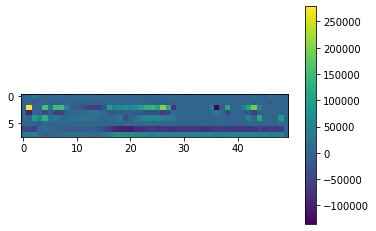

In [10]:
YS_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_G_750_init.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"



plot_ys_init(YS_file, sorted_units_file, save_dir)

In [6]:
YS_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_YS_init.npy") # (2n x 49)
#YS_init = YS_init[:,:30]

YS_pca = PCA(n_components = k_dim)
YS_pca.fit(YS_init)

U_init = YS_pca.transform(YS_init)
V_init = YS_pca.components_

print(V_init.shape)
print(U_init.shape)

np.save(os.path.join(save_dir, "yass_k7_U_init.npy"), U_init)
np.save(os.path.join(save_dir, "yass_k7_V_init.npy"), V_init)

(2, 49)
(4188, 2)


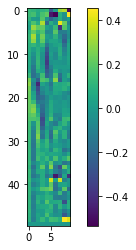

In [11]:
V_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k10_V_750_init.npy")
plt.imshow(V_init.T)
plt.colorbar()

def plot_u_init(U_file, sorted_units_file, save_dir):
    U = np.load(U_file)
    sorted_units = np.load(sorted_units_file)
    
    ids = sorted_units[:35]
    unit_ids = np.empty(ids.shape[0]*2)
    
    for i in range(ids.shape[0]):
        unit = ids[i]
        unit_ids[i*2] = np.int(2*unit)
        unit_ids[i*2 + 1] = np.int(2*unit) + 1
    
    unit_ids = unit_ids.astype(int)

    plt.figure(figsize = (5,8))
    plt.imshow(U[unit_ids, :])
    plt.colorbar()
    



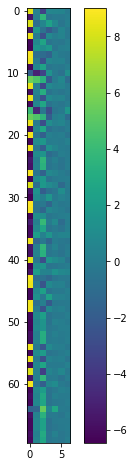

In [8]:
U_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k7_U_init.npy"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"

plot_u_init(U_file, sorted_units_file, save_dir)

## G_PCA Graphs

'\nplt.plot(np.arange(var_ratios.shape[0]), cum_var_ratios)\nplt.xticks(np.arange(0, 51, 5))\nplt.yticks(np.arange(0,1.01, 0.1))\nplt.xlabel("Principal Components")\nplt.ylabel("% Variance Explained")\n'

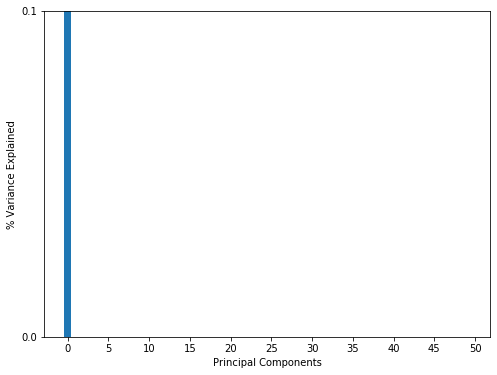

In [8]:
G_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_hand_UV_init.npy") # (2n x 50)

G_pca = PCA()
G_pca.fit(G_init)

U_init = G_pca.transform(G_init)
V_init = G_pca.components_
var_ratios = G_pca.explained_variance_ratio_
cum_var_ratios = np.empty((var_ratios.shape[0]))

for i in range(var_ratios.shape[0]):
    cum_ratio = np.sum(var_ratios[:i])
    cum_var_ratios[i] = cum_ratio

plt.figure(figsize = (8,6))
plt.bar(np.arange(var_ratios.shape[0]), var_ratios)
plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0,1, 0.1))
plt.xlabel("Principal Components")
plt.ylabel("% Variance Explained")
plt.ylim(0,0.1)

"""
plt.plot(np.arange(var_ratios.shape[0]), cum_var_ratios)
plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0,1.01, 0.1))
plt.xlabel("Principal Components")
plt.ylabel("% Variance Explained")
"""

# Neural Network Optimization

In [3]:


class LinearNet(nn.Module):
    def __init__(self, unit_no, t_dim, k_dim, f_dim, p_dim):
        super(LinearNet, self).__init__()
        self.unit_no = unit_no
        self.t_dim = t_dim
        self.k_dim = k_dim
        self.f_dim = f_dim
        self.p_dim = p_dim
        
        self.V = nn.Linear(t_dim, k_dim).cuda()
        self.U_list = nn.ModuleList([nn.Linear(k_dim, f_dim).cuda() for i in range(unit_no)]).cuda()
        self.W_list = nn.ModuleList([nn.Linear(f_dim, p_dim).cuda() for i in range(unit_no)]).cuda()
        
    def forward(self, S):
        self.batch = S.shape[0]
        
        ###### (50n) --> (kn) ####
        VS = torch.empty(self.batch, self.k_dim * self.unit_no).cuda()
        
        for i in range(self.unit_no):
            S_i = S[:, self.t_dim*i : self.t_dim*(i+1)].float().cuda()
            VS_i = self.V(S_i)
            VS[:, self.k_dim*i : self.k_dim*(i+1)] = VS_i
            
        ###### (kn) --> (2n) #####
        UVS = torch.empty(self.batch, self.f_dim * self.unit_no).cuda()
            
        for i in range(self.unit_no):
            VS_i = VS[:, self.k_dim*i : self.k_dim*(i+1)].float().cuda()
            U_i_func = self.U_list[i]
            UVS_i = U_i_func(VS_i)
            UVS[:, self.f_dim*i : self.f_dim*(i+1)] = UVS_i
        
        ##### (2n) --> (p) #####
        I = torch.zeros(self.batch, self.p_dim).cuda()
 
        for i in range(self.unit_no):
            UVS_i = UVS[:, self.f_dim*i : self.f_dim*(i+1)].float().cuda()
            W_i_func = self.W_list[i]
            I_i = W_i_func(UVS_i)
            I += I_i
        
        return I.float()

In [4]:
"""
MODEL, OPTIMIZER, DATA
"""

W_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy")
W_init = torch.from_numpy(W_init)



U_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k10_U_750_init.npy")
U_init = torch.from_numpy(U_init)

V_init = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k10_V_750_init.npy")
V_init = torch.from_numpy(V_init)
#V_init = torch.cat((V_init.float(), 0.1*torch.randn(k_dim, 1).float()), dim=1)

"""
U_init = torch.eye(2)
U_init = U_init.repeat(unit_no, 1)
V_init = torch.zeros(2, 50)
V_init[0,3:16] = 1
V_init[1,17:31] = 1
"""

S_init = np.load("/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy") # (m x n x 50)

neural = S_init.reshape((S_init.shape[0], S_init.shape[1] * S_init.shape[2]))[:9792,:]
neural = torch.from_numpy(neural)
image_no = neural.shape[0]
unit_no = S_init.shape[1]

images = np.load("/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy") # (m x p)
images = torch.from_numpy(images[:9792,:])

batch_count = int(image_no / batch_size)

model = LinearNet(unit_no, t_dim, k_dim, f_dim, p_dim)
model = model.float()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

milestones = [batch_count // 2, batch_count * 3 // 4, batch_count * 7//8]
lr_decay = 0.5

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones,
                                                gamma=lr_decay)





FileNotFoundError: [Errno 2] No such file or directory: '/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy'

In [ ]:
model.state_dict()["V.weight"][:] = V_init

for i in tnrange(unit_no):
    model.state_dict()["U_list."+str(i)+".weight"][:] = U_init[2*i : 2*(i+1),  : ]
    model.state_dict()["W_list."+str(i)+".weight"][:] = W_init[ 2*i : 2*(i+1) , :].T
    


In [ ]:
##### FOR K=2 BASELINE COMPARISON
####
#model.V.weight.requires_grad = False
#model.V.bias.requires_grad = False

#for i in tnrange(unit_no):
    #model.U_list[i].weight.requires_grad = False
    #model.U_list[i].bias.requires_grad = False
#####
#####

In [ ]:
"""
TRAINING LOOP
"""
batch_corr_array = np.empty((batch_count * 1, 1))

batch_ids_1 = np.arange(9792)
np.random.shuffle(batch_ids_1)
batch_ids_1 = batch_ids_1.reshape((-1,32))

batch_ids_2 = np.arange(9792)
np.random.shuffle(batch_ids_2)
batch_ids_2 = batch_ids_2.reshape((-1,32))

shuffled_ids = np.vstack((batch_ids_1, batch_ids_2))
shuffled_ids = torch.from_numpy(shuffled_ids).cuda()

for i in range(batch_count * 1):
    start_time = time.time()
    
    ids = shuffled_ids[i,:]
    
    batch_neural = neural[ids,:].cuda()
    batch_images = images[ids,:].cuda()
    
    #batch_neural = neural[batch_size*i : batch_size*(i+1), :].cuda()
    #batch_images = images[batch_size*i : batch_size*(i+1), :].cuda()
    
    optimizer.zero_grad()
    decoded = model(batch_neural.float())
    
    batch_corr = audtorch.pearsonr(batch_images, decoded)
    mean_batch_corr = torch.mean(batch_corr)
    #loss_fn = torch.nn.MSELoss()
    #loss = loss_fn(batch_images, decoded)
    
    loss = -torch.log(mean_batch_corr*0.5 + 0.25)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    batch_corr_array[i] = mean_batch_corr.detach().cpu().numpy()
    
    end_time = time.time()
    duration = end_time - start_time
    
    print("Iter " +str(i)+ " Batch_Corr: " + str(mean_batch_corr.item()) + " , Time: " +str(duration))
    
np.save(os.path.join(save_dir, "yass_I2_lnn_batch_corr.npy"), batch_corr_array)

In [7]:
torch.save(model.state_dict(), os.path.join(save_dir, "yass_I2_reduced_lnn_model.pt"))

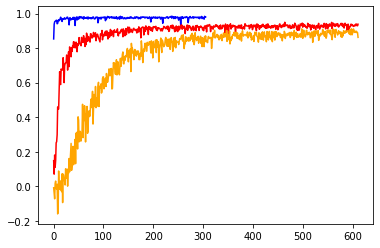

In [9]:
corr_array_1 = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k10_lnn_batch_corr.npy")
corr_array_2 = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_I2_lnn_batch_corr.npy")
corr_array_3 = np.load("/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k7_lnn_batch_corr.npy")
plt.plot(np.arange(corr_array_1.shape[0]), corr_array_1, color = "red")
plt.plot(np.arange(corr_array_2.shape[0]), corr_array_2, color = "blue")
plt.plot(np.arange(corr_array_3.shape[0]), corr_array_3, color = "orange")